# Data Prep & Modeling
## Filtering

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

marte_raw = pd.read_csv('marte_vs_nlwest_19_22.csv',
                        usecols=['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'pitcher', 'zone', 'des', 'p_throws', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name', 'spin_axis'])

# rename the primary response variable
marte_raw.rename(columns={'estimated_woba_using_speedangle': 'xwOBA'}, inplace=True)
print(f"data-set shape prior to filtering: {marte_raw.shape}")

# filter sacrifice events; if woba_denom is NaN, then sacrifice event
marte_raw.dropna(axis='rows', subset=['woba_denom'], how='any', inplace=True)
print(f"data-set shape after to filtering sac hits: {marte_raw.shape}")

# filter missing observation data
marte_raw.dropna(axis='rows', subset=['release_spin_rate', 'spin_axis'], how='any', inplace=True)
print(f"data-set shape after to filtering missing spin observations: {marte_raw.shape}")

data-set shape prior to filtering: (867, 30)
data-set shape after to filtering sac hits: (865, 30)
data-set shape after to filtering missing spin observations: (859, 30)


- release_speed
    - Pitch velocities from 2008-16 are via Pitch F/X, and adjusted to roughly out-of-hand release point. All velocities from 2017 and beyond are Statcast, which are reported out-of-hand.
- release_pos_x
    - horizontal Release Position of the ball measured in feet from the catcher's perspective.
- release_pos_z
    - Vertical Release Position of the ball measured in feet from the catcher's perspective.
- plate_x
    - Horizontal position of the ball when it crosses home plate from the catcher's perspective.
- plate_z
    - Vertical position of the ball when it crosses home plate from the catcher's perspective.
- pitcher
    - MLB Player Id tied to the play event.
- zone
    - Zone location of the ball when it crosses the plate from the catcher's perspective.
- pfx_x
    - Horizontal movement in feet from the catcher's perspective.
- pfx_z
    - Vertical movement in feet from the catcher's perpsective.
- effective_speed
    - Derived speed based on the the extension of the pitcher's release.
- release_spin
    - Spin rate of pitch tracked by Statcast.
- spin_axis
    - The Spin Axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball

## Filtering ext., Computed Features, NaN Conversions

In [2]:
import numpy as np
import math

# filter raw set with proposed model metrics
marte_vs = marte_raw.drop(columns=['game_date', 'release_pos_x', 'release_pos_z', 'des', 'bb_type', 'balls', 'strikes', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_extension', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name'])
print(f"new data-set shape after to filtering for proper metrics: {marte_vs.shape}")

# vectorize the horizontal & vertical movement using pythagorean theorem
marte_vs['pfx_v'] = np.sqrt(marte_vs.pfx_x ** 2 + marte_vs.pfx_z ** 2)

print(f"number of NaN xwOBA PAs prior to conversion: {marte_vs.xwOBA.isnull().sum()}")

# convert xwOBA stat to include .7 for walks and 0.0 for strikeouts
# if the xwOBA stat is NaN, then need to use the woba_value
# converts 184 NaN occurrences
marte_vs['xwOBA'] = marte_vs.apply(lambda x: x.woba_value if math.isnan(x.xwOBA) else x.xwOBA, axis=1)

print(f"number of valid xwOBA PAs after conversion: {marte_vs.xwOBA.notnull().sum()}")

# reorder columns for logical readability
marte_vs = marte_vs.reindex(columns=['xwOBA', 'woba_value', 'game_year', 'pitcher', 'p_throws', 'pitch_type', 'release_speed', 'release_spin_rate', 'spin_axis', 'zone', 'pfx_x', 'pfx_z', 'pfx_v'])

print(marte_vs.head())

new data-set shape after to filtering for proper metrics: (859, 12)
number of NaN xwOBA PAs prior to conversion: 184
number of valid xwOBA PAs after conversion: 859
   xwOBA  woba_value  game_year  pitcher p_throws pitch_type  release_speed  \
0  0.709         0.9       2022   596001        R         SI           92.9   
1  0.262         0.0       2022   596001        R         SI           92.6   
2  0.231         0.0       2022   596001        R         SI           93.0   
3  0.117         0.0       2022   518397        L         SI           93.3   
4  0.438         0.0       2022   502171        R         SI           94.1   

   release_spin_rate  spin_axis  zone  pfx_x  pfx_z     pfx_v  
0             2303.0      211.0     5  -1.15   0.68  1.336001  
1             2316.0      204.0     9  -1.05   0.80  1.320038  
2             2245.0      219.0     8  -1.13   0.79  1.378768  
3             2189.0      135.0     8   1.19   0.28  1.222497  
4             2126.0      221.0     4  -

In [3]:
# exploration
import seaborn as sns

# sns.pairplot(marte_vs[['xwOBA', 'woba_value', 'p_throws', 'pitch_type', 'release_speed', 'release_spin_rate', 'spin_axis', 'zone', 'pfx_x', 'pfx_z', 'pfx_v']], corner=True, hue='pitch_type')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


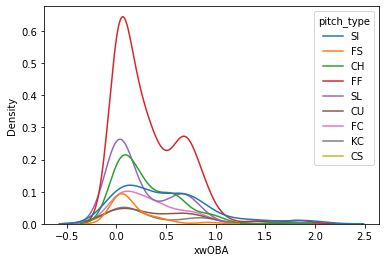

In [4]:
sns.kdeplot(marte_vs.xwOBA, hue=marte_vs.pitch_type)

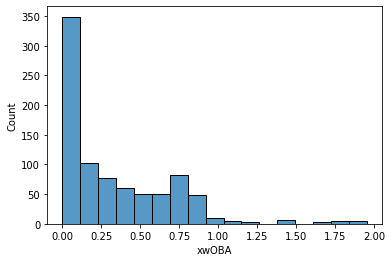

In [5]:
sns.histplot(marte_vs, x='xwOBA')  # show need for response transformation

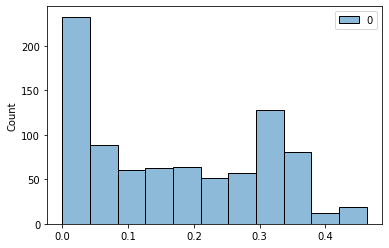

In [6]:
from sklearn.preprocessing import PowerTransformer

# Yeo-Johnson transformation of output
pt_out = PowerTransformer(standardize=False)
# extract target and convert to 1D array
y_xwOBA = marte_vs.xwOBA.to_numpy().reshape(-1, 1)
# transformation
trx_xwOBA = pt_out.fit_transform(y_xwOBA)
sns.histplot(trx_xwOBA)

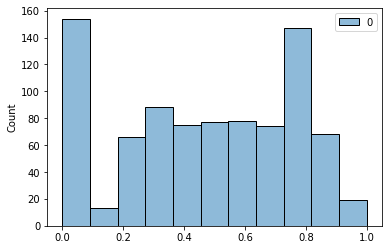

In [7]:
from sklearn.preprocessing import QuantileTransformer, quantile_transform
# qt transformation output

qt_xwOBA = quantile_transform(y_xwOBA, n_quantiles=6, output_distribution="uniform", copy=True)
sns.histplot(qt_xwOBA)

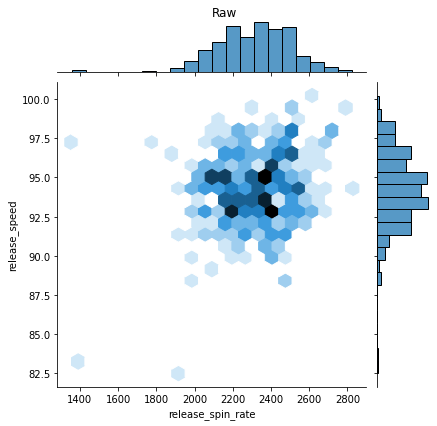

In [8]:
ff = marte_vs.groupby(['pitch_type']).get_group('FF')
g = sns.jointplot(data=ff, x='release_spin_rate', y='release_speed', kind='hex')
g.fig.suptitle("Raw")
g.fig.subplots_adjust(top=0.95)

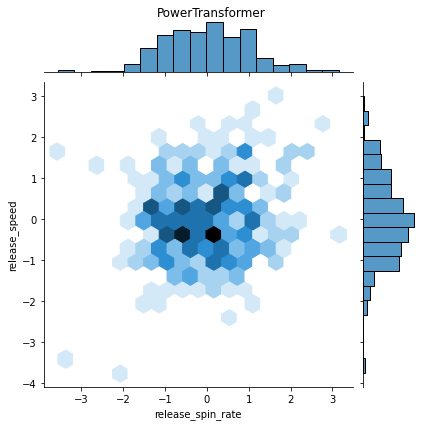

In [9]:
# used for positive values
pt = PowerTransformer(method='box-cox')
bc_trx = pt.fit_transform(ff[['release_spin_rate', 'release_speed']])
# convert to df
bc_trx = pd.DataFrame(bc_trx, columns=pt.get_feature_names_out())

g = sns.jointplot(data=bc_trx, x='release_spin_rate', y='release_speed', kind='hex')
g.fig.suptitle("PowerTransformer")
g.fig.subplots_adjust(top=0.95)

## Transformations
### Dummies
A common mistake is to apply transformations to the entire data before splitting into training and test sets. This will bias the model evaluation because information would have leaked from the test set to the training set.

In [10]:
marte_vs_trx = pd.get_dummies(data=marte_vs, columns=['pitch_type', 'zone'])
marte_vs_trx = pd.get_dummies(data=marte_vs_trx, columns=['p_throws'], drop_first=True)
marte_vs_trx.head()

,xwOBA,woba_value,game_year,pitcher,release_speed,release_spin_rate,spin_axis,pfx_x,pfx_z,pfx_v,...,zone_5,zone_6,zone_7,zone_8,zone_9,zone_11,zone_12,zone_13,zone_14,p_throws_R
0,0.709,0.9,2022,596001,92.9,2303.0,211.0,-1.15,0.68,1.336001,...,1,0,0,0,0,0,0,0,0,1
1,0.262,0.0,2022,596001,92.6,2316.0,204.0,-1.05,0.80,1.320038,...,0,0,0,0,1,0,0,0,0,1
2,0.231,0.0,2022,596001,93.0,2245.0,219.0,-1.13,0.79,1.378768,...,0,0,0,1,0,0,0,0,0,1
3,0.117,0.0,2022,518397,93.3,2189.0,135.0,1.19,0.28,1.222497,...,0,0,0,1,0,0,0,0,0,0
4,0.438,0.0,2022,502171,94.1,2126.0,221.0,-1.34,0.45,1.413542,...,0,0,0,0,0,0,0,0,0,1


### Feature and output transformations

In [11]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X = marte_vs_trx.drop(columns=['xwOBA', 'pfx_x', 'pfx_z'])  # remove response var and extra features
y = marte_vs.xwOBA
# split data into training and testing sets

X = sm.add_constant(X)   # only needed for sm (not smf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1642)

print('Train set shape\n', X_train.shape, y_train.shape)
print('Test set shape\n', X_test.shape, y_test.shape)
print('---')

# transform numerical data
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

num_feats = ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v']
# used for positive values
pt = PowerTransformer()
# get a transformed series of numerical features
X_train_trx = pt.fit_transform(X_train[num_feats])
# overwrite raw numerical data
X_train[num_feats] = X_train_trx

# transform the test set with the trained lambdas
X_test_trx = pt.transform(X_test[num_feats])
# overwrite raw numerical dataframe
X_test[num_feats] = X_test_trx
############################
# # transform output
qt = QuantileTransformer(n_quantiles=600).fit(y_train.to_numpy().reshape(-1, 1))
y_train_trx = pd.Series(map(lambda x: x[0], qt.transform(y_train.to_numpy().reshape(-1, 1))), index=y_train.index)
# quantile transform on the test output, converted to a pandas.Series with the original indicies
y_test_trx = pd.Series(map(lambda x: x[0], qt.transform(y_test.to_numpy().reshape(-1, 1))), index=y_test.index)

print('Train trx set shape\n', X_train_trx.shape, y_train_trx.shape)
print('Test trx set shape\n', X_test_trx.shape, y_test_trx.shape)
print('---')

Train set shape
 (601, 31) (601,)
Test set shape
 (258, 31) (258,)
---
Train trx set shape
 (601, 4) (601,)
Test trx set shape
 (258, 4) (258,)
---


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## Modeling
### Naive Model
*Note: did not transform the output for the naive model.

In [12]:
# Marte's xwOBA for last 4 seasons ('19-'22) == .348
from sklearn.metrics import *

print(y.mean())
y_same_xwOBA = pd.Series(.348, index=range(0, y_train.size))
# if squared is false then rmse
naive_rmse = mean_squared_error(y_true=y_train, y_pred=y_same_xwOBA, squared=False)
print(f"naive mse: {naive_rmse}")

naive_r2 = r2_score(y_true=y_train, y_pred=y_same_xwOBA)
print(f"naive r2 score: {naive_r2}")

0.33073573923166477
naive mse: 0.35266608058144583
naive r2 score: -0.0016667766402074236


### Classical Modeling
#### Model 1 -- OLS full feature

In [13]:
model1_feats = ['const', 'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v', 'pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12', 'zone_13', 'zone_14', 'p_throws_R']
model1 = sm.OLS(endog=y_train_trx, exog=X_train[model1_feats])
results1 = model1.fit()
print(results1.summary())
print('--------------')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     2.538
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           6.76e-05
Time:                        20:43:14   Log-Likelihood:                -115.56
No. Observations:                 601   AIC:                             283.1
Df Residuals:                     575   BIC:                             397.5
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3749      0.04

model1 mse: 0.32689662459851815
model r2 score: -0.02541768835217728


/usr/local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

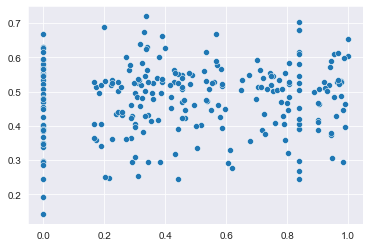

In [ ]:
# model 1 evaluation
xwOBA_pred1 = results1.predict(X_test[model2_feats])
# xwOBA_pred1 = qt.inverse_transform(xwOBA_pred1)
m1_mse = mean_squared_error(y_test_trx, xwOBA_pred1, squared=False)
print(f"model1 mse: {m1_mse}")

m1_r2 = r2_score(y_test_trx, xwOBA_pred1)
print(f"model r2 score: {m1_r2}")

sns.scatterplot(y_test_trx, xwOBA_pred1)

#### Model 2 -- OLS backward selection p-val

In [ ]:
# removed release_speed, p_throws_R, all zones, pfx_v
model2_feats = ['const', 'release_spin_rate', 'spin_axis', 'pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL']
model1 = sm.OLS(endog=y_train_trx, exog=X_train[model2_feats])
results2 = model1.fit()
print(results2.summary())
print('--------------')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     4.579
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           2.79e-06
Time:                        15:29:27   Log-Likelihood:                -124.55
No. Observations:                 601   AIC:                             271.1
Df Residuals:                     590   BIC:                             319.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3891      0.03

model2 mse: 0.33025024826139504
model r2 score: -0.04656507486950523


/usr/local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

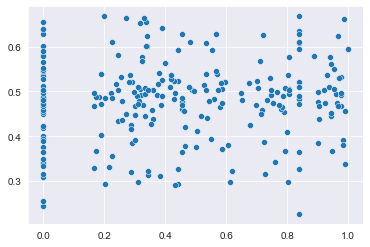

In [ ]:
xwOBA_pred2 = results2.predict(X_test[model2_feats])

m2_mse = mean_squared_error(y_test_trx, xwOBA_pred2, squared=False)
print(f"model2 mse: {m2_mse}")

m2_r2 = r2_score(y_test_trx, xwOBA_pred2)
print(f"model r2 score: {m2_r2}")

sns.scatterplot(y_test_trx, xwOBA_pred2)

#### Model 3 RFE | 3.5 Ridge regression

model3 mse: 0.32374144805608285
model r2 score: -0.005718738733639039


/usr/local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

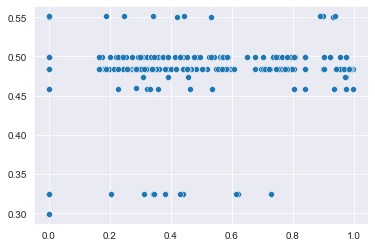

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge, LinearRegression

model = Ridge()

model3_feats = ['const', 'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v', 'pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12', 'zone_13', 'zone_14', 'p_throws_R']

# Search the best k features for k = 1 to x
# for k in range(1, 29):
#     rfe = RFE(estimator=model, n_features_to_select=k)
#
#     fit = rfe.fit(X_train[model3_feats], y_train_trx)
#
#     f = fit.get_support(1) #the most important features
#
#     final_features = X_train[X_train.columns[f]] # final features
#
#     print("Num Features: %d" % fit.n_features_)
#     print("Selected Features: %s" % final_features.columns)
#     print("Score: %2.2f" % fit.score(X_test[model3_feats], y_test_trx))
#
#     print("----------")

model3 = Ridge().fit(X=X_train[['spin_axis', 'pitch_type_CU', 'pitch_type_FF', 'pitch_type_FS',
                              'zone_9']], y=y_train_trx)
y_pred_mod3 = model3.predict(X_test[['spin_axis', 'pitch_type_CU', 'pitch_type_FF', 'pitch_type_FS',
                        'zone_9']])

m3_mse = mean_squared_error(y_test_trx, y_pred_mod3, squared=False)
print(f"model3 mse: {m3_mse}")

m3_r2 = r2_score(y_test_trx, y_pred_mod3)
print(f"model r2 score: {m3_r2}")

sns.scatterplot(y_test_trx, y_pred_mod3)

In [ ]:
# try groupby pitch_type
# convert pitch dummies to single column
org_pit_col_train = pd.from_dummies(X_train[['pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL']], sep='pitch_type_')
# drop dummy pitch_types from transformed train set
X_train_grp_pit = X_train.drop(columns=['pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL'], axis=1)
# # add back zipped column, need to use .values attribute or will have index issues
X_train_grp_pit['pitch_type'] = org_pit_col_train.values
# # groupby pitch_type
X_train_ff = X_train_grp_pit.groupby(['pitch_type']).get_group('FF')

#### Model 4 -- Single pitch filter

In [ ]:
# model4_feats = ['const', 'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12', 'zone_13', 'zone_14', 'p_throws_R']
# idx_ff = y_train_trx.index.intersection(X_train_ff.index)
# y_train_trx_ff = y_train_trx.iloc[[670]]
# # model4 = sm.OLS(endog=y_train_trx_ff, exog=X_train_ff[model4_feats])
# # results4 = model4.fit()
# # print(results4.summary())

### NN
#### Model 1

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Dropout, BatchNormalization


# normalizer = preprocessing.Normalization()
# normalizer.adapt(np.array(train_features))
X_1 = X_train.release_spin_rate
X_1_test = X_test.release_spin_rate
number_of_inputs = 1  # number of features
model = keras.Sequential([layers.Dense(16, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(16, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

print("Fit model on training data")
history = model.fit(
    X_1,
    y_train_trx,
    batch_size=42,
    epochs=16,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_1_test, y_test_trx),
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_1_test, y_test_trx, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_1_test.iloc[:42,])
print("predictions shape:", predictions.shape)

Fit model on training data
Epoch 1/16
15/15 [==============================] - 1s 10ms/step - loss: 0.2741 - root_mean_squared_error: 0.5235 - mean_absolute_error: 0.4384 - val_loss: 0.2006 - val_root_mean_squared_error: 0.4479 - val_mean_absolute_error: 0.3663
Epoch 2/16
15/15 [==============================] - 0s 2ms/step - loss: 0.1789 - root_mean_squared_error: 0.4229 - mean_absolute_error: 0.3549 - val_loss: 0.1581 - val_root_mean_squared_error: 0.3976 - val_mean_absolute_error: 0.3287
Epoch 3/16
15/15 [==============================] - 0s 2ms/step - loss: 0.1491 - root_mean_squared_error: 0.3861 - mean_absolute_error: 0.3256 - val_loss: 0.1478 - val_root_mean_squared_error: 0.3845 - val_mean_absolute_error: 0.3171
Epoch 4/16
15/15 [==============================] - 0s 2ms/step - loss: 0.1372 - root_mean_squared_error: 0.3704 - mean_absolute_error: 0.3128 - val_loss: 0.1364 - val_root_mean_squared_error: 0.3693 - val_mean_absolute_error: 0.3061
Epoch 5/16
15/15 [==================

#### NN2 -- Higher Fidelity Model

In [ ]:
X_feats2 = ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v', 'pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12', 'zone_13', 'zone_14', 'p_throws_R']
X_full = X_train[X_feats2]
X_full_test = X_test[X_feats2]
number_of_inputs = X_full.shape[1]  # number of features
model = keras.Sequential([layers.Dense(16, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(16, activation='relu'),
                          layers.Dense(16, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=32,
    epochs=16,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=16)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_full_test.iloc[:42,])
print("predictions shape:", predictions.shape)

Fit model on training data
Epoch 1/16
19/19 [==============================] - 1s 9ms/step - loss: 0.1412 - root_mean_squared_error: 0.3757 - mean_absolute_error: 0.3124 - val_loss: 0.1230 - val_root_mean_squared_error: 0.3508 - val_mean_absolute_error: 0.2951
Epoch 2/16
19/19 [==============================] - 0s 2ms/step - loss: 0.1097 - root_mean_squared_error: 0.3312 - mean_absolute_error: 0.2766 - val_loss: 0.1133 - val_root_mean_squared_error: 0.3365 - val_mean_absolute_error: 0.2868
Epoch 3/16
19/19 [==============================] - 0s 2ms/step - loss: 0.1025 - root_mean_squared_error: 0.3201 - mean_absolute_error: 0.2681 - val_loss: 0.1107 - val_root_mean_squared_error: 0.3328 - val_mean_absolute_error: 0.2839
Epoch 4/16
19/19 [==============================] - 0s 2ms/step - loss: 0.0995 - root_mean_squared_error: 0.3154 - mean_absolute_error: 0.2645 - val_loss: 0.1103 - val_root_mean_squared_error: 0.3321 - val_mean_absolute_error: 0.2850
Epoch 5/16
19/19 [===================

In [ ]:
from tensorflow.keras import regularizers

X_feats3 = ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v', 'pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL']
X_full = X_train[X_feats3]
X_full_test = X_test[X_feats3]
number_of_inputs = X_full.shape[1]  # number of features
model = keras.Sequential([layers.Dense(16, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(), bias_regularizer=regularizers.l1()),
                          layers.Dense(16, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=32,
    epochs=4000,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
    callbacks=[callback]
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=16)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_full_test.iloc[:42,])
print("predictions shape:", predictions.shape)

Fit model on training data
Epoch 1/4000
19/19 [==============================] - 1s 11ms/step - loss: 1.9125 - root_mean_squared_error: 0.5307 - mean_absolute_error: 0.4402 - val_loss: 1.7097 - val_root_mean_squared_error: 0.4046 - val_mean_absolute_error: 0.3356
Epoch 2/4000
19/19 [==============================] - 0s 2ms/step - loss: 1.6027 - root_mean_squared_error: 0.3746 - mean_absolute_error: 0.3116 - val_loss: 1.4957 - val_root_mean_squared_error: 0.3613 - val_mean_absolute_error: 0.3074
Epoch 3/4000
19/19 [==============================] - 0s 2ms/step - loss: 1.3995 - root_mean_squared_error: 0.3438 - mean_absolute_error: 0.2927 - val_loss: 1.3114 - val_root_mean_squared_error: 0.3506 - val_mean_absolute_error: 0.2985
Epoch 4/4000
19/19 [==============================] - 0s 2ms/step - loss: 1.2214 - root_mean_squared_error: 0.3327 - mean_absolute_error: 0.2833 - val_loss: 1.1425 - val_root_mean_squared_error: 0.3436 - val_mean_absolute_error: 0.2921
Epoch 5/4000
19/19 [========

#### Hyper sweep

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_and_compile_model():
    # create model
    model = keras.Sequential([layers.Dense(16, activation='relu', input_dim=number_of_inputs),
                              layers.Dense(16, activation='relu'),
                              layers.Dense(1, activation='linear') ]) # output layer for regression

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
    return model

model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)

# define the grid search parameters
batch_size = [8, 16, 32, 64, 128]
epochs = [10, 50, 250, 1250]

param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)

grid_result = grid.fit(X_full, y_train_trx)

/var/folders/nz/57m0v30s0kqdtdm5876x20qw0000gn/T/ipykernel_54900/1658499985.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)


7/7 [==============================] - 0s 564us/step


In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

params = grid_result.cv_results_['params']

for mean, param in zip(means, params):
    print("train accuracy %f for: %r" % (mean, param))

Best: -0.445794 using {'batch_size': 8, 'epochs': 10}
train accuracy -0.445794 for: {'batch_size': 8, 'epochs': 10}
train accuracy -0.445794 for: {'batch_size': 8, 'epochs': 50}
train accuracy -0.445794 for: {'batch_size': 8, 'epochs': 250}
train accuracy -0.448029 for: {'batch_size': 8, 'epochs': 1250}
train accuracy -0.445794 for: {'batch_size': 16, 'epochs': 10}
train accuracy -0.445794 for: {'batch_size': 16, 'epochs': 50}
train accuracy -0.445794 for: {'batch_size': 16, 'epochs': 250}
train accuracy -0.446772 for: {'batch_size': 16, 'epochs': 1250}
train accuracy -0.445794 for: {'batch_size': 32, 'epochs': 10}
train accuracy -0.445794 for: {'batch_size': 32, 'epochs': 50}
train accuracy -0.445794 for: {'batch_size': 32, 'epochs': 250}
train accuracy -0.446008 for: {'batch_size': 32, 'epochs': 1250}
train accuracy -0.480993 for: {'batch_size': 64, 'epochs': 10}
train accuracy -0.445794 for: {'batch_size': 64, 'epochs': 50}
train accuracy -0.445794 for: {'batch_size': 64, 'epochs': 

In [ ]:
def create_and_compile_model(num_neurons, num_layers):
    # create model
    model = keras.Sequential()
    model.add(Dense(num_neurons, input_dim=number_of_inputs, activation='relu'))

    if num_layers > 0:

        while num_layers > 0:
            model.add(Dense(num_neurons, activation='relu'))
            num_layers=num_layers-1


    model.add(Dense(1, activation='linear')) # output layer for regression

    # Compile model
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

    print(model.summary())
    print('--')

    return model

model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)

# define the grid search parameters
num_neurons_grid = [4, 8, 16]
num_layers_grid = [1, 2, 3, 4]

param_grid = dict(num_neurons=num_neurons_grid, num_layers=num_layers_grid)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)

grid_result = grid.fit(X_full, y_train_trx)

/var/folders/nz/57m0v30s0kqdtdm5876x20qw0000gn/T/ipykernel_54900/3761777028.py:25: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 4)                 56        
                                                                 
 dense_77 (Dense)            (None, 4)                 20        
                                                                 
 dense_78 (Dense)            (None, 1)                 5         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 4)                 56        
                                                                 
 dense_51 (Dense)            (None

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

params = grid_result.cv_results_['params']

for mean, param in zip(means, params):
    print("train accuracy %f for: %r" % (mean, param))

Best: -0.529124 using {'num_layers': 4, 'num_neurons': 8}
train accuracy -0.561702 for: {'num_layers': 1, 'num_neurons': 4}
train accuracy -0.556701 for: {'num_layers': 1, 'num_neurons': 8}
train accuracy -0.574411 for: {'num_layers': 1, 'num_neurons': 16}
train accuracy -0.543553 for: {'num_layers': 2, 'num_neurons': 4}
train accuracy -0.576415 for: {'num_layers': 2, 'num_neurons': 8}
train accuracy -0.554089 for: {'num_layers': 2, 'num_neurons': 16}
train accuracy -0.576415 for: {'num_layers': 3, 'num_neurons': 4}
train accuracy -0.576415 for: {'num_layers': 3, 'num_neurons': 8}
train accuracy -0.568254 for: {'num_layers': 3, 'num_neurons': 16}
train accuracy -0.576415 for: {'num_layers': 4, 'num_neurons': 4}
train accuracy -0.529124 for: {'num_layers': 4, 'num_neurons': 8}
train accuracy -0.559542 for: {'num_layers': 4, 'num_neurons': 16}


#### Combining Sweep
layers = 4
neurons = 8
batch_size = 8
epochs = 10

In [ ]:
model = keras.Sequential([layers.Dense(8, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(8, activation='relu'),
                          layers.Dense(8, activation='relu'),
                          layers.Dense(8, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=8,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
    callbacks=[callback]
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=16)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_full_test.iloc[:42,])
print("predictions shape:", predictions.shape)

Fit model on training data
Epoch 1/10
76/76 [==============================] - 1s 3ms/step - loss: 0.1418 - root_mean_squared_error: 0.3766 - mean_absolute_error: 0.3126 - val_loss: 0.1180 - val_root_mean_squared_error: 0.3435 - val_mean_absolute_error: 0.2829
Epoch 2/10
76/76 [==============================] - 0s 1ms/step - loss: 0.1078 - root_mean_squared_error: 0.3283 - mean_absolute_error: 0.2748 - val_loss: 0.1108 - val_root_mean_squared_error: 0.3328 - val_mean_absolute_error: 0.2804
Epoch 3/10
76/76 [==============================] - 0s 1ms/step - loss: 0.1016 - root_mean_squared_error: 0.3188 - mean_absolute_error: 0.2688 - val_loss: 0.1087 - val_root_mean_squared_error: 0.3297 - val_mean_absolute_error: 0.2814
Epoch 4/10
76/76 [==============================] - 0s 1ms/step - loss: 0.0975 - root_mean_squared_error: 0.3122 - mean_absolute_error: 0.2636 - val_loss: 0.1051 - val_root_mean_squared_error: 0.3243 - val_mean_absolute_error: 0.2760
Epoch 5/10
76/76 [===================

In [ ]:
factor = 0.01
model = keras.Sequential([layers.Dense(8, activation='relu', input_dim=number_of_inputs, kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=8,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
    callbacks=[callback]
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=16)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_full_test.iloc[:42,])
print("predictions shape:", predictions.shape)

Fit model on training data
Epoch 1/10
76/76 [==============================] - 1s 3ms/step - loss: 0.4859 - root_mean_squared_error: 0.4510 - mean_absolute_error: 0.3685 - val_loss: 0.3570 - val_root_mean_squared_error: 0.3318 - val_mean_absolute_error: 0.2806
Epoch 2/10
76/76 [==============================] - 0s 1ms/step - loss: 0.3172 - root_mean_squared_error: 0.3181 - mean_absolute_error: 0.2702 - val_loss: 0.2909 - val_root_mean_squared_error: 0.3237 - val_mean_absolute_error: 0.2764
Epoch 3/10
76/76 [==============================] - 0s 2ms/step - loss: 0.2606 - root_mean_squared_error: 0.3110 - mean_absolute_error: 0.2649 - val_loss: 0.2460 - val_root_mean_squared_error: 0.3219 - val_mean_absolute_error: 0.2763
Epoch 4/10
76/76 [==============================] - 0s 1ms/step - loss: 0.2206 - root_mean_squared_error: 0.3080 - mean_absolute_error: 0.2625 - val_loss: 0.2135 - val_root_mean_squared_error: 0.3217 - val_mean_absolute_error: 0.2773
Epoch 5/10
76/76 [===================

TW NN

# of inputs = 31
Epoch 1/100
15/15 [==============================] - 1s 17ms/step - loss: 0.2267 - mse: 0.2267 - val_loss: 0.1954 - val_mse: 0.1954
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1951 - mse: 0.1951 - val_loss: 0.1769 - val_mse: 0.1769
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1765 - mse: 0.1765 - val_loss: 0.1627 - val_mse: 0.1627
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.1620 - mse: 0.1620 - val_loss: 0.1524 - val_mse: 0.1524
Epoch 5/100
15/15 [==============================] - 0s 6ms/step - loss: 0.1516 - mse: 0.1516 - val_loss: 0.1443 - val_mse: 0.1443
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1433 - mse: 0.1433 - val_loss: 0.1371 - val_mse: 0.1371
Epoch 7/100
15/15 [==============================] - 0s 6ms/step - loss: 0.1359 - mse: 0.1359 - val_loss: 0.1316 - val_mse: 0.1316
Epoch 8/100
15/15 [==============================] - 0s 5ms/step 

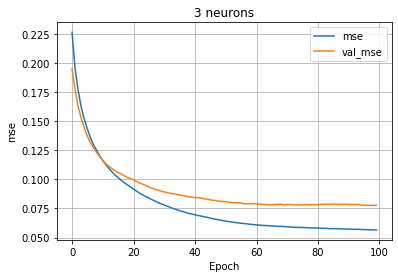

19/19 [==============================] - 0s 2ms/step
MAE Train = 0.19313649882254705
MSE Train = 0.06055212746448455
R2  = 0.5123308384216427

9/9 [==============================] - 0s 2ms/step
MAE Test = 0.20948664478183718
MSE Test = 0.07017835501106408
R2  = 0.5123904397312322


In [21]:
# Define the loss plot
def plot_loss(history, num_neurons):
  plt.plot(history.history['mse'], label='mse')
  plt.plot(history.history['val_mse'], label='val_mse')
  # plt.ylim([0, y_lim])
  plt.xlabel('Epoch')
  plt.ylabel('mse')
  plt.legend()
  plt.title(f"{num_neurons} neurons")

  plt.grid(True)
  plt.show()
  

import numpy as np
import tensorflow as tf
from   tensorflow import keras
from   tensorflow.keras import layers, regularizers
from   tensorflow.keras.layers.experimental import preprocessing
import matplotlib
import matplotlib.pyplot as plt
from   tensorflow.keras.optimizers import Adam

#setup normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

number_of_inputs= X_train.shape[1]
print(f"# of inputs = {number_of_inputs}")

num_neurons = 3

# create model
model = keras.Sequential([normalizer,
                          layers.Dense(num_neurons, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(num_neurons, activation='relu'),
                          layers.Dense(1, activation='linear') ])  
  
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics='mse')

history = model.fit(X_train, 
                    y_train, 
                    batch_size=32,
                    epochs=100,
                    validation_split = 0.2)  # Calculate validation results on 20% of the training data
                  
# Isolate and plot training curves 
hist = pd.DataFrame(history.history)
plot_loss(history, num_neurons)

# calculate metrics ---------------
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# train
y_pred = model.predict(X_train)
print(f"MAE Train = {mean_absolute_error(y_train, y_pred)}")
print(f"MSE Train = { mean_squared_error(y_train, y_pred)}")
print(f"R2  = {                 r2_score(y_train, y_pred)}")
print(f"")

# holdout
y_pred = model.predict(X_test)
print(f"MAE Test = {mean_absolute_error(y_test, y_pred)}")
print(f"MSE Test = { mean_squared_error(y_test, y_pred)}")
print(f"R2  = {                r2_score(y_test, y_pred)}")

TW NN neurons sweep

Epoch 1/100
15/15 [==============================] - 2s 52ms/step - loss: 0.2369 - mse: 0.2369 - val_loss: 0.2019 - val_mse: 0.2019
Epoch 2/100
15/15 [==============================] - 0s 19ms/step - loss: 0.2274 - mse: 0.2274 - val_loss: 0.1929 - val_mse: 0.1929
Epoch 3/100
15/15 [==============================] - 0s 14ms/step - loss: 0.2187 - mse: 0.2187 - val_loss: 0.1843 - val_mse: 0.1843
Epoch 4/100
15/15 [==============================] - 0s 15ms/step - loss: 0.2104 - mse: 0.2104 - val_loss: 0.1764 - val_mse: 0.1764
Epoch 5/100
15/15 [==============================] - 0s 12ms/step - loss: 0.2028 - mse: 0.2028 - val_loss: 0.1691 - val_mse: 0.1691
Epoch 6/100
15/15 [==============================] - 0s 11ms/step - loss: 0.1957 - mse: 0.1957 - val_loss: 0.1623 - val_mse: 0.1623
Epoch 7/100
15/15 [==============================] - 0s 12ms/step - loss: 0.1893 - mse: 0.1893 - val_loss: 0.1561 - val_mse: 0.1561
Epoch 8/100
15/15 [==============================] - 0s 6ms/step - loss: 0.1

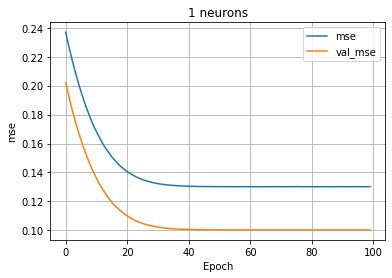

Epoch 1/100
15/15 [==============================] - 1s 15ms/step - loss: 0.5566 - mse: 0.5566 - val_loss: 0.4226 - val_mse: 0.4226
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.4866 - mse: 0.4866 - val_loss: 0.3728 - val_mse: 0.3728
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4310 - mse: 0.4310 - val_loss: 0.3308 - val_mse: 0.3308
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.3853 - mse: 0.3853 - val_loss: 0.2966 - val_mse: 0.2966
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.3462 - mse: 0.3462 - val_loss: 0.2698 - val_mse: 0.2698
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.3166 - mse: 0.3166 - val_loss: 0.2465 - val_mse: 0.2465
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.2907 - mse: 0.2907 - val_loss: 0.2272 - val_mse: 0.2272
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.2684 - 

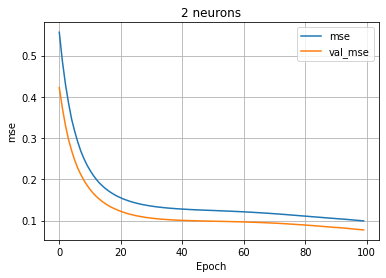

Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 0.2348 - mse: 0.2348 - val_loss: 0.1608 - val_mse: 0.1608
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.2021 - mse: 0.2021 - val_loss: 0.1405 - val_mse: 0.1405
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.1774 - mse: 0.1774 - val_loss: 0.1272 - val_mse: 0.1272
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1603 - mse: 0.1603 - val_loss: 0.1197 - val_mse: 0.1197
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1488 - mse: 0.1488 - val_loss: 0.1140 - val_mse: 0.1140
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1402 - mse: 0.1402 - val_loss: 0.1100 - val_mse: 0.1100
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1348 - mse: 0.1348 - val_loss: 0.1071 - val_mse: 0.1071
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: 0.1307 - 

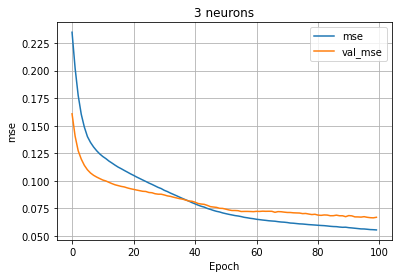

Epoch 1/100
15/15 [==============================] - 1s 15ms/step - loss: 1.3519 - mse: 1.3519 - val_loss: 0.9691 - val_mse: 0.9691
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0238 - mse: 1.0238 - val_loss: 0.7522 - val_mse: 0.7522
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7936 - mse: 0.7936 - val_loss: 0.5985 - val_mse: 0.5985
Epoch 4/100
15/15 [==============================] - 0s 22ms/step - loss: 0.6370 - mse: 0.6370 - val_loss: 0.4827 - val_mse: 0.4827
Epoch 5/100
15/15 [==============================] - 0s 8ms/step - loss: 0.5148 - mse: 0.5148 - val_loss: 0.3986 - val_mse: 0.3986
Epoch 6/100
15/15 [==============================] - 0s 9ms/step - loss: 0.4287 - mse: 0.4287 - val_loss: 0.3335 - val_mse: 0.3335
Epoch 7/100
15/15 [==============================] - 0s 6ms/step - loss: 0.3622 - mse: 0.3622 - val_loss: 0.2842 - val_mse: 0.2842
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.3121 -

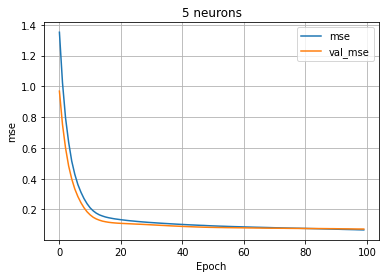

Epoch 1/100
15/15 [==============================] - 1s 22ms/step - loss: 0.3341 - mse: 0.3341 - val_loss: 0.2431 - val_mse: 0.2431
Epoch 2/100
15/15 [==============================] - 0s 12ms/step - loss: 0.2570 - mse: 0.2570 - val_loss: 0.2034 - val_mse: 0.2034
Epoch 3/100
15/15 [==============================] - 0s 9ms/step - loss: 0.2107 - mse: 0.2107 - val_loss: 0.1775 - val_mse: 0.1775
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: 0.1814 - mse: 0.1814 - val_loss: 0.1596 - val_mse: 0.1596
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1602 - mse: 0.1602 - val_loss: 0.1454 - val_mse: 0.1454
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.1448 - mse: 0.1448 - val_loss: 0.1342 - val_mse: 0.1342
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.1326 - mse: 0.1326 - val_loss: 0.1263 - val_mse: 0.1263
Epoch 8/100
15/15 [==============================] - 0s 7ms/step - loss: 0.1232 -

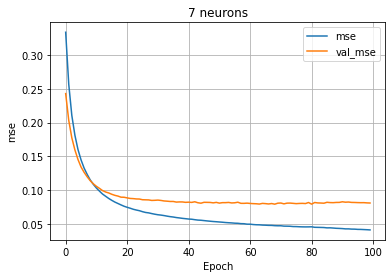

Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 0.4175 - mse: 0.4175 - val_loss: 0.3386 - val_mse: 0.3386
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.2979 - mse: 0.2979 - val_loss: 0.2617 - val_mse: 0.2617
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.2348 - mse: 0.2348 - val_loss: 0.2142 - val_mse: 0.2142
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.1926 - mse: 0.1926 - val_loss: 0.1847 - val_mse: 0.1847
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1678 - mse: 0.1678 - val_loss: 0.1645 - val_mse: 0.1645
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1487 - mse: 0.1487 - val_loss: 0.1508 - val_mse: 0.1508
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.1339 - mse: 0.1339 - val_loss: 0.1403 - val_mse: 0.1403
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1223 - 

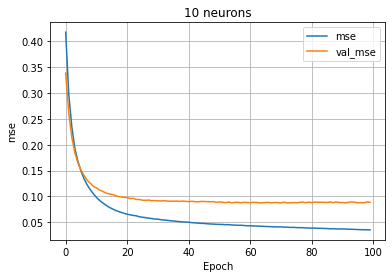

Epoch 1/100
15/15 [==============================] - 1s 15ms/step - loss: 0.9782 - mse: 0.9782 - val_loss: 0.5289 - val_mse: 0.5289
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.5124 - mse: 0.5124 - val_loss: 0.2909 - val_mse: 0.2909
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.3379 - mse: 0.3379 - val_loss: 0.2098 - val_mse: 0.2098
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.2486 - mse: 0.2486 - val_loss: 0.1717 - val_mse: 0.1717
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.2006 - mse: 0.2006 - val_loss: 0.1521 - val_mse: 0.1521
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1706 - mse: 0.1706 - val_loss: 0.1395 - val_mse: 0.1395
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1494 - mse: 0.1494 - val_loss: 0.1295 - val_mse: 0.1295
Epoch 8/100
15/15 [==============================] - 0s 6ms/step - loss: 0.1334 - 

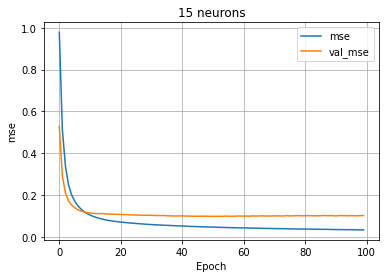

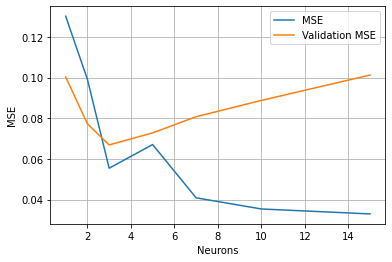

In [19]:
# Define the loss plot
def plot_loss(history):
  plt.plot(history.history['mse'], label='mse')
  plt.plot(history.history['val_mse'], label='val_mse')
  # plt.ylim([0, y_lim])
  plt.xlabel('Epoch')
  plt.ylabel('mse')
  plt.legend()
  plt.title(f"{num_neurons} neurons")

  plt.grid(True)
  plt.show()


from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization

#setup normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

number_of_inputs= X_train.shape[1]

# sweep neurons
mse_list = []
val_mse_list = []

neurons_to_try = [1, 2, 3, 5, 7, 10, 15]

for num_neurons in neurons_to_try:

  #---- pasted in model
  model = keras.Sequential([normalizer,
                            layers.Dense(num_neurons, activation='relu', input_dim=number_of_inputs),
                            layers.Dense(num_neurons, activation='relu'),
                            layers.Dense(1, activation='linear') ])  
    
  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics='mse')

  history = model.fit(X_train, y_train, 
                      epochs=100,
                      batch_size = 32,
                      validation_split = 0.2)  # Calculate validation results on 20% of the training data
                    
  # Isolate the metric for each epoch.
  hist = pd.DataFrame(history.history)

  #---- end model paste

  # record metrics

  current_mse=hist['mse']
  current_mse=current_mse[len(current_mse)-1] #  last element is the final value
  mse_list.append(current_mse)  

  current_val_mse=hist['val_mse']
  current_val_mse=current_val_mse[len(current_val_mse)-1] #  last element is the final value
  val_mse_list.append(current_val_mse)

  plot_loss(history)

  # calculate metrics ---------------
  from sklearn.metrics import mean_absolute_error
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import r2_score

  # train
  y_pred = model.predict(X_train)
  print(f"MAE Train = {mean_absolute_error(y_train, y_pred)}")
  print(f"MSE Train = { mean_squared_error(y_train, y_pred)}")
  print(f"R2  = {                 r2_score(y_train, y_pred)}")
  print(f"")

  # holdout
  y_pred = model.predict(X_test)
  print(f"MAE Test = {mean_absolute_error(y_test, y_pred)}")
  print(f"MSE Test = { mean_squared_error(y_test, y_pred)}")
  print(f"R2  = {                r2_score(y_test, y_pred)}")

#plot results of sweep
plt.plot(neurons_to_try, mse_list, label='MSE')
plt.plot(neurons_to_try, val_mse_list, label='Validation MSE')

# plt.ylim([1,y_lim])
plt.xlabel('Neurons')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()